- Nom :GHOUL
- Prenom : Branis
- id : 28612738

# Generative Adversarial Networks

Les réseaux antagonistes génératifs (GAN) sont des architectures algorithmiques qui utilisent deux réseaux de neurones, s'opposant l'un à l'autre (Générateur vs Discriminateur), d'où le « antagoniste ».

Le générateur et le discriminateur jouent à un jeu où ils sont l’un contre l’autre. Ce sont des adversaires (d’où le terme « adversarial »), le générateur tente de tromper le discriminateur tandis que le discriminateur va recevoir en entrée les vraies données et les fausses données, qui ont été générées par le générateur, et tenter de les distinguer.

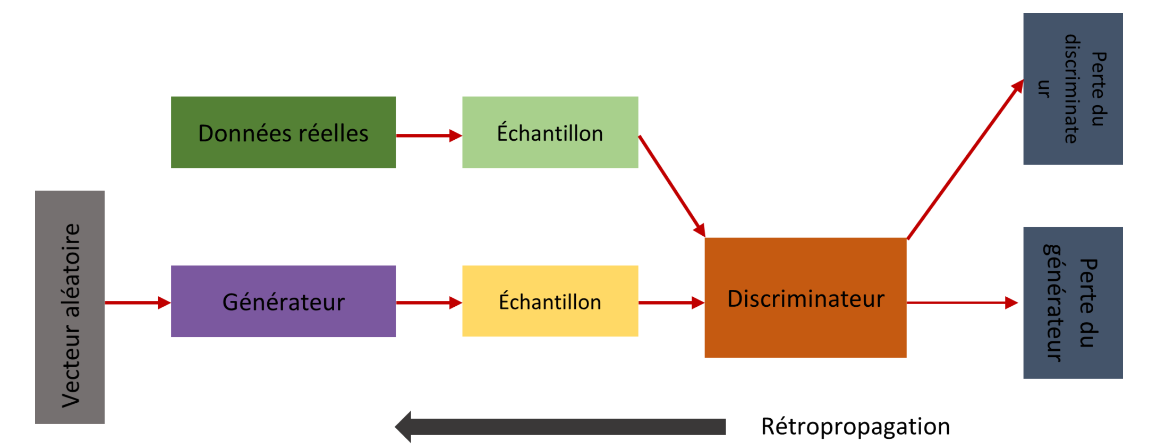


Les GAN sont largement utilisés dans la génération d'images, la génération de vidéos et la génération de voix, afin de générer de nouvelles instances synthétiques de données pouvant passer pour des données réelles.

Le potentiel des GAN c'est leurs possibilité d'apprendre à imiter n'importe quelle distribution de données. Autrement dit, les GAN peuvent apprendre à créer des mondes étrangement similaires au nôtre dans n'importe quel domaine : images, musique, discours, prose. Ce sont des artistes robots dans un sens, et leur production est impressionnante, voire poignante. 

### Objectif

L’objectif de ce TP est d’implémenter une architecture neuronale d'un réseaux génératifs antagonistes (GAN), pour apprendre à générer des images. Nous allons tenter de créer un GAN très simple à l'aide de TensorFlow. Plus précisément, notre objectif sera de former un réseau de neurones capable de générer des images convaincantes/réalistes qui correspondent à la `base de données MNIST`.

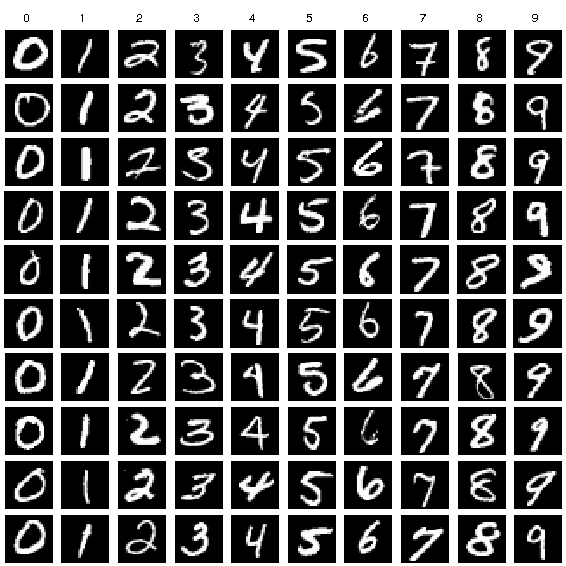

### Installer

Déclaration des dépendances et les paramètres que nous utiliserons tout au long de ce TP.

In [1]:
# Importation of tensorflow 
import tensorflow as tf
tf.config.run_functions_eagerly(False)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [2]:
tf.__version__

'2.9.2'

In [3]:
# Importation of necessary libraries 
import tensorflow.keras.datasets as tfds
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model, load_model, clone_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, concatenate

from IPython import display
import numpy as np
import matplotlib.pyplot as plt

import time
import os
from tqdm import tqdm

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use('seaborn')

### Charger et préparer le jeu de données
Nous utiliserons le jeu de données `MNIST` pour former le générateur et le discriminateur. Le générateur générera des chiffres manuscrits ressemblant aux données MNIST.

In [4]:
# load the mnist dataset 
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 2s 0us/step


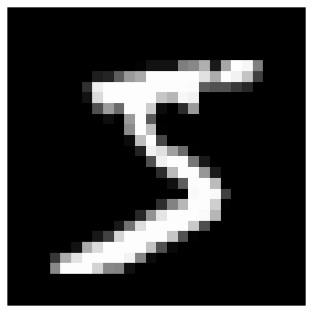

In [5]:
# View some sample images 
plt.imshow(train_images[0], cmap='gray')
plt.axis(False)
plt.grid(False)

In [6]:
# Visualize the dimensions of the dataset
train_images.shape, train_labels.shape

((60000, 28, 28), (60000,))

In [7]:
# Extracts the dimensions of the dataset (number of images, image size) 
nb_images, rows, cols = train_images.shape

In [8]:
# Transformation in tensor form (nb_images, h,w, ch), then normalization of images 
train_images = train_images.reshape(nb_images, rows, cols, 1).astype('float32')
train_images = train_images / 255.0

Définition de certaines variables que nous utiliserons pour configurer les paramètres des couches convolutives, à savoir la dimensionnalité des images que nous traiterons, ainsi que la taille du batch et la taille de la dimension du bruit blanc.

In [9]:
# Initialize constants 
BUFFER_SIZE = nb_images                   # 60000
BATCH_SIZE  = 32                          # The size of the batch 
INPUT_SHAPE_GENERATOR     = 32            # dimonsion of noise tensor
INPUT_SHAPE_DISCRIMINATOR = (rows, cols)  # image size of the mnist dataset

In [10]:
# Batch ans shuffle the data
train_images = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
# train_images = list(train_images.as_numpy_iterator())

In [11]:
# plt.imshow(train_images[0][0], cmap='gray')
# plt.axis(False)
# plt.grid(False)

### Instanciation de G et D
Le générateur et le discriminateur sont définis à l'aide de l' API séquentielle Keras.

##### Le générateur
Le générateur est un réseau de neurones qui a pour but de créer de fausses données qui vont être fournies au discriminateur lors de son entraînement. Il prend en entrée un vecteur aléatoire d’une taille fixe et a pour sortie des données générées.

Le principal objectif du générateur est que les échantillons de la base de fausses données qu’il génère soient classifiés par le discriminateur comme des échantillons de la vraie base de données. Ainsi lorsque D(G(z)) est proche de 1, le générateur a atteint son objectif. Il cherche donc à maximiser D(G(z)), ce qui revient à minimiser 1- D(G(z)).

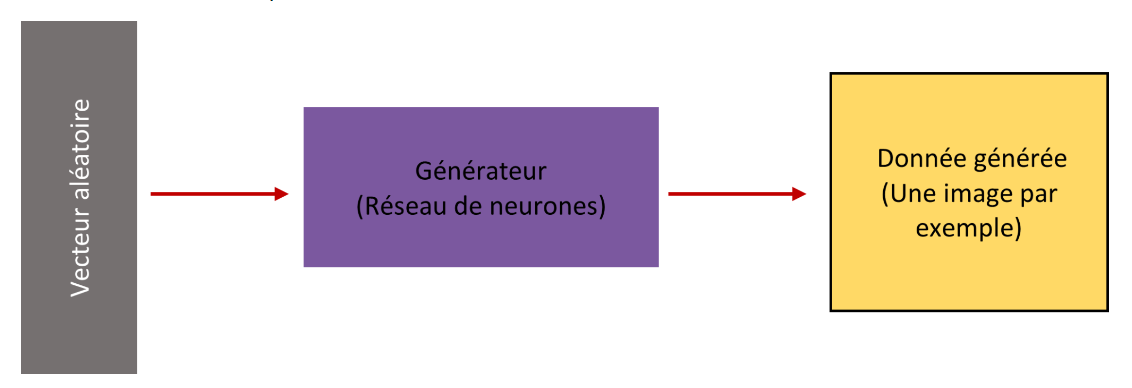

Le générateur est basé sur des convolutions transposées `tf.keras.layers.Conv2DTranspose` (suréchantillonnage) pour produire une image à partir d'un bruit aléatoire en entrée. Nous commençons par une couche `Dense` qui prend ce bruit en entrée, puis nous sur-échantillonnons plusieurs fois jusqu'à atteindre la taille d'image souhaitée de 28x28x1. Chaque couche est suivie d'une activation de `tf.keras.layers.LeakyReLU`, sauf pour la couche de sortie qui utilise `sigmoid`.

1. Créer un générateur G avec une architecture

In [12]:
def make_generator_model():

    model = tf.keras.Sequential()
    model.add(layers.Dense(14*14*128, use_bias=False, input_shape=(INPUT_SHAPE_GENERATOR,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((14, 14, 128)))
    assert model.output_shape == (None, 14, 14, 128)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(32, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 32)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='sigmoid'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

Utilisation du générateur (pas encore formé) pour créer une image (bruit aléatoire).

In [13]:
G = make_generator_model()
G.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 25088)             802816    
                                                                 
 batch_normalization (BatchN  (None, 25088)            100352    
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 25088)             0         
                                                                 
 reshape (Reshape)           (None, 14, 14, 128)       0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 64)       204800    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 64)       2

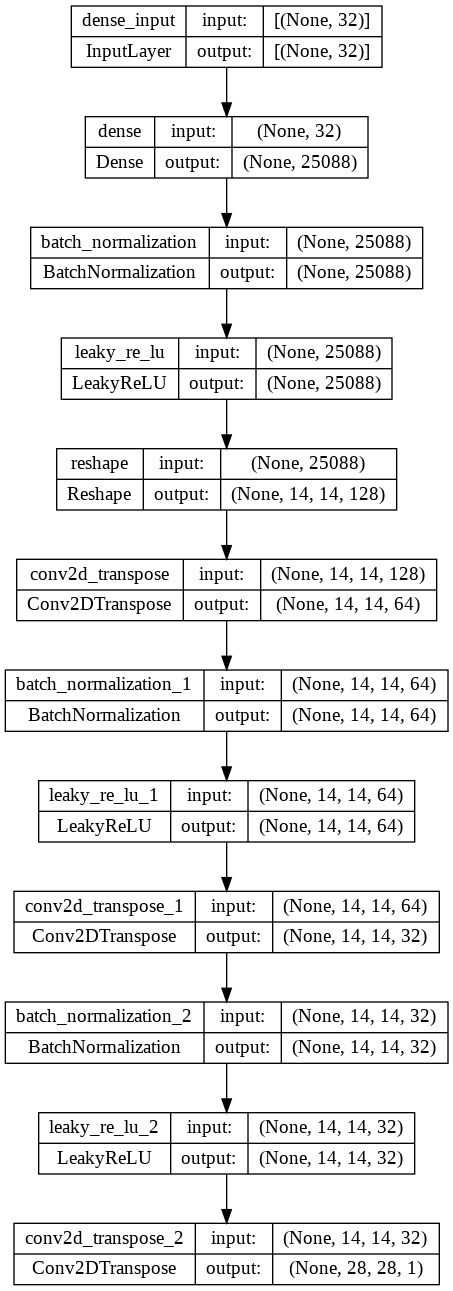

In [14]:
plot_model(G, show_shapes=True, show_layer_names=True)

(-0.5, 27.5, 27.5, -0.5)

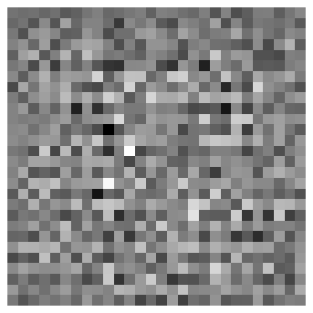

In [15]:
noise = tf.random.normal([1, INPUT_SHAPE_GENERATOR])
generated_image = G(noise, training=False)
plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.grid(False); plt.axis(False)

Comme nous pouvons le voir, la sortie du générateur est une image de lot de dimensions (None, 28, 28, 1). C'est exactement la même paramètres rows, cols que nous avons définie plus tôt. Pour tromper le discriminateur, le générateur doit générer des images qui ont les mêmes dimensions que les images `dataset mnist`.

#### Le discriminateur


2. Créer un discriminateur D avec une architecture CNN.

Le discriminateur est un réseau de neurones qui classifie les données qui lui sont fournies en entrée pour distinguer les vraies données, provenant de la base de données réelles, de celles produites par le générateur.

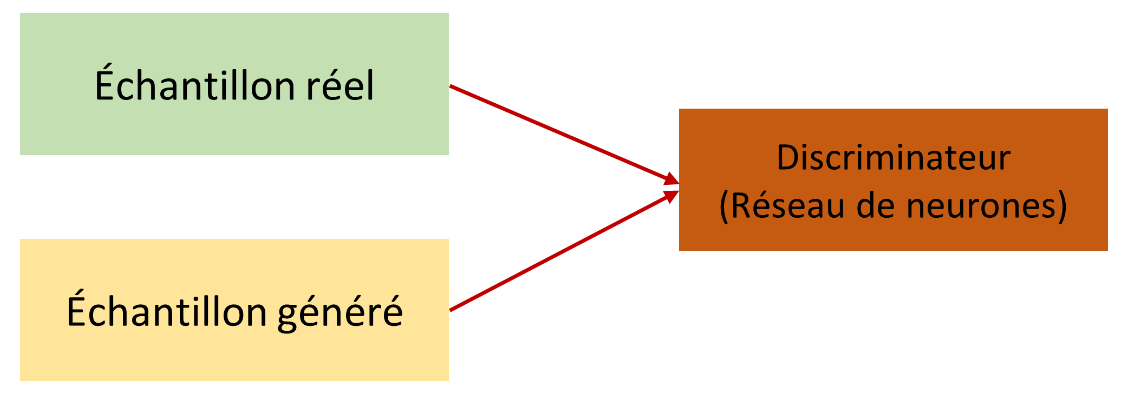

Le discriminateur est un classificateur d'images basé sur CNN.



In [16]:
def make_discriminator_model():
  
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))

    return model

Utilisation du discriminateur (pas encore formé) pour classer les images générées comme réelles ou fausses. Le modèle sera formé pour générer des valeurs positives pour les images réelles et des valeurs négatives pour les images factices.

In [17]:
D = make_discriminator_model()
D.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)             

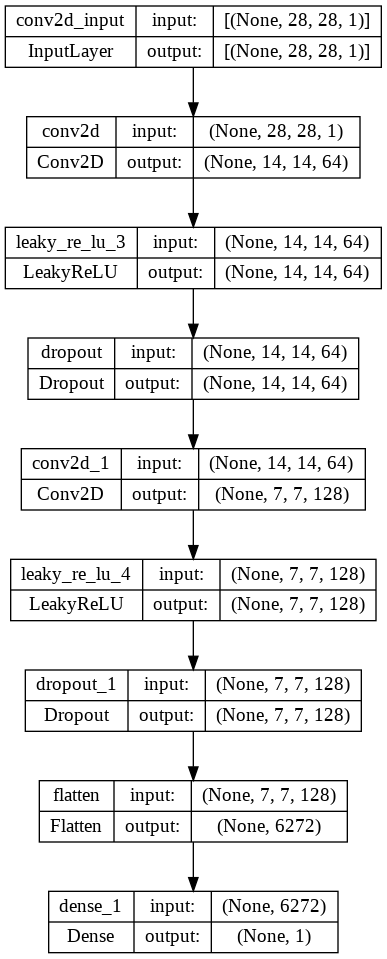

In [18]:
plot_model(D, show_shapes=True, show_layer_names=True)

In [19]:
D(generated_image)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.48391318]], dtype=float32)>

#### Création du GAN

Maintenant que nous avons instancié les deux modules élémentaires `generator` et `decriminator`, nous allons pouvoir créer le réseau `GAN` utilisé pour l’apprentissage antagoniste.

Comme nous l’avons décrit au début du TP, un GAN est composé d’un générateur et d’un discriminateur. Le générateur prend en entrée un vecteur latent aléatoire `noise` et a pour sortie une donnée générée `G(Z)`. Nous notons `x` un échantillon de la base de données réelles. Nous supposons que `X` suit une distribution de probabilité `p_x` qui est la distribution des échantillons dans la base de données réelles. L’objectif du GAN (generative adversarial network) est d’approcher la distribution `p_x` par la distribution `p_g` qui est la distribution de probabilité des échantillons de la base de données générées `G(noise)`. `X` et `G(Z)` sont donnés en entrée au discriminateur qui va tenter de différencier les vraies données des fausses données.  

Par la suit on notera :
- D(x) la prédiction du discriminateur pour les données réelles.
- D(G(z)) la prédiction du discriminateur pour les données générées.

#### Définir la fonction de perte et les optimisateurs


3. Définir les fonctions de perte et les optimiseurs pour les deux modèles.

Pour la partie du discriminateur D, sufit simplement de compiler le module D avec la loss `binary_crossentropy` et l’optimiseur `Adam`. Ensuite, nous utilisons la fonction `summary` pour visualiser l’architecture du réseau D.


In [20]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

In [21]:
D.compile(optimizer='Adam', loss=cross_entropy, metrics=['accuracy'])

In [22]:
D.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)             

4. Pour la partie du générateur G, l’apprentissage consiste à optimiser les poids du générateur G pour un état donné du discriminateur D

— Faire une recopie du discriminateur `D` pour créer le discriminateur
`discriminateur_gan`.  
— Déclarer les poids de ce discriminateur comme non-entrainables, en fixant la valeur de son attribut `trainable` à False.  
— Instancier le réseau `GAN`, avec comme entrée la taille du code latent aléatoire et comme sortie la composition de `discriminator_gan(generator(gan_input))`.  
— Définir la loss `binary_crossentropy` et l’optimiseur Adam.  

In [23]:
discriminator_gan = clone_model(D)
discriminator_gan.compile(optimizer='Adam', loss=cross_entropy, metrics=['accuracy'])
discriminator_gan.trainable = False

In [24]:
gan_input = tf.keras.layers.Input([INPUT_SHAPE_GENERATOR,])
gan_output = discriminator_gan(G(gan_input))
GAN = Model(gan_input, gan_output)
GAN.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32)]              0         
                                                                 
 sequential (Sequential)     (None, 28, 28, 1)         1160352   
                                                                 
 sequential_1 (Sequential)   (None, 1)                 212865    
                                                                 
Total params: 1,373,217
Trainable params: 1,109,984
Non-trainable params: 263,233
_________________________________________________________________


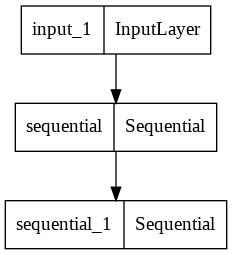

In [25]:
tf.keras.utils.plot_model(GAN, to_file= 'GAN.png')

In [26]:
GAN.compile(optimizer='Adam', loss=cross_entropy, metrics=['accuracy'])

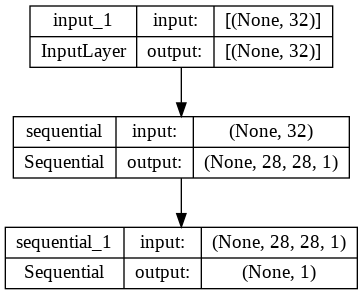

In [27]:
plot_model(GAN, show_shapes=True, show_layer_names=True)

#### Apprentissage du GAN

Nous allons maintenant procédé à l’apprentissage alterné des poids du générateur G et du discriminateur. Pour ce faire, nous allons créer notre propre boucle pour traiter les batches. Essentiellement, cette boucle crée des étiquettes binaires pour les images réelles et fausses. Rappelons que le but du discriminateur est de réussir à discerner les images générées des vraies. Rappelons-nous également que pour créer des images générées, le générateur doit échantillonner à partir d'une dimension latente. En d'autres termes, la formation comprendra les étapes suivantes :

5. Réaliser un tirage aléatoire du code latent, en utilisant un tirage aléatoire dans une distribution normale. Pour ce faire on utilisera la fonction `random de numpy` ou `random de tensorflow`.  
6. Réaliser la prédiction des images générées à partir de `G` et du code latent.  
7. Construire un mélange d’images réelles tirées aléatoirement et d’images générées avec les labels correspondant.  
8. Entrainer le discriminateur `D` à partir de ce mélange. On utilisera la méthode `train_on_batch`.  
9. Réaliser un nouveau tirage aléatoire du code latent, et créer les labels correspondants à "réel".  
10. Entrainer le réseau antagoniste à partir de ces données. On utilisera la méthode `train_on_batch`.  
Nous ferons un affichage des losses du discriminateur D et réseau antagoniste GAN toutes les 10 époques, et un tracé de 10 images produites par le générateur.  

In [54]:
def train_step(real_images, gan, generator):
  noise = np.random.normal(loc=0.0, scale=1.0, size=(BATCH_SIZE, INPUT_SHAPE_GENERATOR))
  generated_images = generator(noise, training=True)
  combined_images = np.concatenate([generated_images.numpy(), real_images])
  labels = np.concatenate([np.zeros((BATCH_SIZE, 1)),
                           np.ones((BATCH_SIZE, 1))])
  labels += 0.05 * np.random.random(labels.shape) # astuce trover sur internet
  
  d_loss, d_acc = discriminator_gan.train_on_batch(combined_images, labels)
  noise = np.random.normal(loc=0.0, scale=1.0, size=(BATCH_SIZE, INPUT_SHAPE_GENERATOR))
  misleading_labels = np.ones((BATCH_SIZE, 1))
  gan_loss, gan_acc = gan.train_on_batch(noise, misleading_labels)

  return d_loss, d_acc, gan_loss, gan_acc

#### Générer et enregistrer des images

In [55]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 255.0, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

#### Générer et enregistrer des images

In [59]:

def train(dataset, gan, generator, epochs=50, num_examples_to_generate=16):
  history = { 'd_loss'   : [],
              'd_acc'    : [],
              'gan_loss' : [],
              'gan_acc'  : [] }
  
  checkpoint_dir = '/content/training_checkpoints'
  checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
  checkpoint = tf.train.Checkpoint(generator_optimizer=tf.keras.optimizers.Adam(),
                                   gan_optimizer=tf.keras.optimizers.Adam(), 
                                   generator=generator,
                                   gan=gan) 
  
  seed = tf.random.normal([num_examples_to_generate, INPUT_SHAPE_GENERATOR])
  for epoch in range(epochs):
    seed = tf.random.normal([num_examples_to_generate, INPUT_SHAPE_GENERATOR])
    start = time.time()

    for image_batch in tqdm(dataset):
      d_loss, d_acc, gan_loss, gan_acc  = train_step(image_batch, gan, generator)
      history['d_loss'].append(d_loss), history['d_acc'].append(d_acc)
      history['gan_loss'].append(gan_loss), history['gan_acc'].append(gan_acc)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print("Iteration {0}/{1} : {2} sec".format(epoch+1, epochs, time.time()-start))
    print("[==============================] d-loss: {0:.3f}, gan-loss: {1:.3f}, d-acc: {0:.3f}, gan-acc: {1:.3f}".format(
            history['d_loss'][-1], history['gan_loss'][-1], 
            history['d_acc'][-1], history['gan_acc'][-1]))

    # print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

  return generator, gan, history


In [60]:
# tf.test.is_gpu_available()
tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


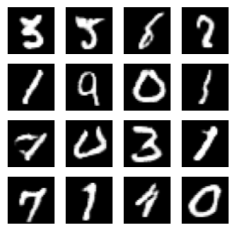

Iteration 101/150 : 65.0722644329071 sec
[==============================] d-loss: 0.594, gan-loss: 1.173, d-acc: 0.594, gan-acc: 1.173


 89%|████████▊ | 1663/1875 [00:57<00:06, 30.34it/s]

In [ ]:
generator, gan, history = train(train_images, GAN, G, epochs=150)

In [34]:
def show_generated_image(generator_model, latent_dim, row_num=4, fig_size=(5, 5)):
  num_image = row_num**2
  random_latent_vectors = np.random.normal(size=(num_image, latent_dim))
  generated_images = generator_model.predict(random_latent_vectors)
  plt.figure(figsize=fig_size)
  for i in range(num_image):
    img = image.array_to_img(generated_images[i] * 255., scale=False)
    plt.subplot(row_num,row_num,i+1)
    plt.grid(False)
    plt.xticks([]); plt.yticks([])
    plt.imshow(img)
  plt.show()

1/1 [==============================] - 0s 15ms/step


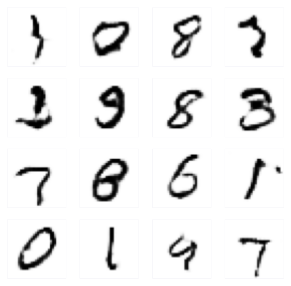

In [44]:
show_generated_image(G, 32, row_num=4)

In [45]:
def plot_learning_curve(history, figsize=(10, 5)):
  # Create a grid of subplots.
  fig, axes = plt.subplots(1, 2, figsize=figsize)
  # Create list of axes for easy iteration.
  if isinstance(axes, np.ndarray):
      # https://stackoverflow.com/questions/46862861/what-does-axes-flat-in-matplotlib-do
      list_axes = list(axes.flat)
  else:
      list_axes = [axes]

  # for i in range(2): 
  #   list_axes[i].set_axis_off(); list_axes[i].grid(False)

  # loss curves
  list_axes[0].plot(history['d_loss'], color='skyblue')
  list_axes[0].plot(history['gan_loss'], color='gold')
  list_axes[0].set_title('loss curves')
  list_axes[0].set_xlabel('Epochs'); 
  list_axes[0].set_ylabel('Cross Entropy Loss')

  # accuracy curves
  list_axes[1].plot(history['d_acc'], color='skyblue')
  list_axes[1].plot(history['gan_acc'], color='gold')
  list_axes[1].set_title('accuracy curves')
  list_axes[1].set_xlabel('Epochs'); 
  list_axes[1].set_ylabel('Cross Entropy Loss')

  plt.show()

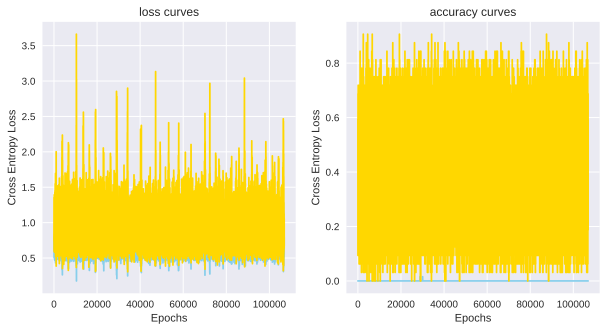

In [46]:
plot_learning_curve(history, figsize=(10, 5))

Comme nous pouvons le constater ici, la perte est très épineuse et erratique. C'est pourquoi il est difficile de déterminer quand arrêter la formation d'un GAN. Bien sûr, il y a des signes évidents d'échec : lorsque la perte d'un composant commence à devenir exponentiellement plus grande ou plus petite que celle de son concurrent, par exemple. Cependant, cela ne s'est pas produit ici, j'ai donc laissé la formation se poursuivre jusqu'à ce que le nombre spécifié d'interactions soit terminé. Les résultats, comme indiqué ci-dessus, suggèrent que nous n'avons pas échoué dans notre tâche.

### Conclusion 
Contrairement aux autres modèles de réseau de neurones profond que l’on entraîne avec une fonction de perte objective jusqu’à la convergence du modèle, le GAN (generative adversarial network) n’a pas de fonction de perte objective. En effet, le générateur et le discriminateur ont chacun leur propre fonction de perte qui ne peuvent pas être minimisées simultanément. De plus, l’équilibre recherché est un équilibre de Nash. On ne peut donc pas observer l’avancement de l’entraînement et la qualité du modèle uniquement avec la fonction de perte. Ce qui complique l’entraînement des GANs.  

Dans le cas de la génération d’image, on évalue la qualité du modèle en regardant la qualité des images générées.

Dans le cas plus général, des mesures quantitatives existent comme l’Inception score et la distance de Fréchet.